In [64]:
pip install -U finance-datareader


Note: you may need to restart the kernel to use updated packages.


In [65]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [66]:
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt


In [67]:
df = fdr.DataReader('005930', '2018-05-04', '2020-01-22')
df.head()


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-05-04,53000,53900,51800,51900,39565391,-0.020755
2018-05-08,52600,53200,51900,52600,23104720,0.013487
2018-05-09,52600,52800,50900,50900,16128305,-0.032319
2018-05-10,51700,51700,50600,51600,13905263,0.013752
2018-05-11,52000,52200,51200,51300,10314997,-0.005814


In [68]:
def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)


In [69]:
dfx = df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]
dfx = dfx[['Open','High','Low','Volume']]
dfx


,Open,High,Low,Volume
Date,,,,
2018-05-04,0.633401,0.646825,0.601610,0.595060
2018-05-08,0.617108,0.619048,0.605634,0.316465
2018-05-09,0.617108,0.603175,0.565392,0.198390
2018-05-10,0.580448,0.559524,0.553320,0.160765
2018-05-11,0.592668,0.579365,0.577465,0.100000
...,...,...,...,...
2020-01-16,0.881874,0.916667,0.891348,0.168830
2020-01-17,0.995927,0.968254,0.971831,0.196653
2020-01-20,1.000000,1.000000,1.000000,0.137469


In [70]:
# 두 데이터를 리스트 형태로 저장
X = dfx.values.tolist()
y = dfy.values.tolist()


In [71]:
window_size = 10

data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)


[[0.7637474541720417, 0.7857142857111677, 0.7665995975824281, 0.323174686971615], [0.8533604887948947, 0.8333333333300265, 0.8269617706204146, 0.33335345138624783], [0.8696537678172315, 0.8769841269806469, 0.8631790744432065, 0.19622106804249292], [0.9022403258619053, 0.8888888888853615, 0.8953722333967993, 0.117672127572782], [0.9348268839065791, 0.9285714285677438, 0.927565392350392, 0.21155713424914332], [0.898167006106321, 0.8730158730124087, 0.8873239436584011, 0.1674615836301646], [0.8818737270839841, 0.9166666666630291, 0.8913480885276002, 0.16882989330989187], [0.9959266802403425, 0.968253968250126, 0.9718309859115821, 0.19665250042066781], [0.9999999999959267, 0.9999999999960317, 0.9999999999959758, 0.13746944253371812], [0.9999999999959267, 0.9841269841230789, 0.9798792756499803, 0.11400880277083453]] -> [0.9959919839639438]


In [72]:
print('전체 데이터의 크기 :', len(data_X), len(data_y))


전체 데이터의 크기 : 411 411


In [73]:
#학습에 사용할 훈련 데이터와 테스트 데이터를 분리해봅시다. 비율은 7:3으로 하고자 합니다.
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)


훈련 데이터의 크기 : (287, 10, 4) (287, 1)
테스트 데이터의 크기 : (124, 10, 4) (124, 1)


In [74]:
# 필요한 라이브러리 임포트
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [75]:
# PyTorch 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [76]:
# NumPy 배열을 PyTorch 텐서로 변환
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

In [77]:
# 모델 인스턴스화, 손실 함수 및 옵티마이저 설정
model = LSTMModel(input_dim=4, hidden_dim=50, num_layers=3, output_dim=1)
criterion = nn.MSELoss()  # 회귀 문제의 경우 MSE 사용
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 학습률 예시로 0.001 사용

In [78]:
# 학습 루프
num_epochs = 70  # 에포크 수 예시로 100 사용
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    # train_X_tensor와 train_y_tensor는 실제 훈련 데이터와 레이블을 PyTorch 텐서로 변환한 것입니다.
    # 실제 데이터에 맞게 변환하는 코드를 추가해야 합니다.
    output = model(train_X_tensor)  
    loss = criterion(output, train_y_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:  # 10 에포크마다 로스 출력
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/70], Loss: 0.1209
Epoch [11/70], Loss: 0.0127
Epoch [21/70], Loss: 0.0118
Epoch [31/70], Loss: 0.0134
Epoch [41/70], Loss: 0.0112
Epoch [51/70], Loss: 0.0100
Epoch [61/70], Loss: 0.0090


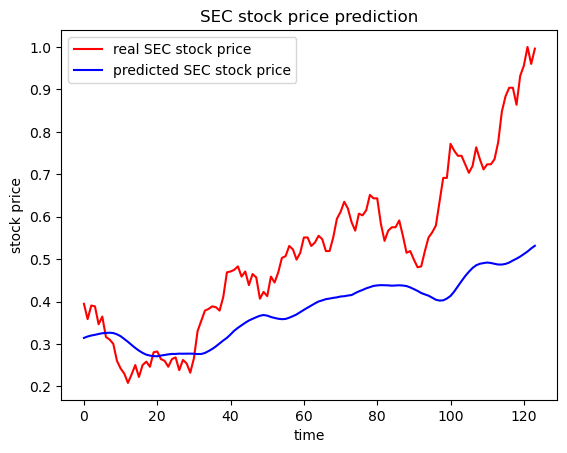

내일 SEC 주가 : [33242.754] KRW


In [79]:
import matplotlib.pyplot as plt
import torch

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터를 모델에 전달하여 예측 수행
# test_X_tensor는 이미 텐서로 변환된 테스트 데이터
with torch.no_grad():
    pred_y_tensor = model(test_X_tensor)

# 예측 결과를 numpy 배열로 변환
pred_y = pred_y_tensor.numpy()

# 실제 데이터와 예측 결과 시각화
plt.figure()
plt.plot(test_y, color='red', label='real SEC stock price')
plt.plot(pred_y, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# 내일 SEC 주가 계산 (예시 코드, 실제 코드에서는 df와 dfy의 구조에 따라 조정 필요)
# df와 dfy는 실제 데이터프레임의 예시 이름이며, 실제 사용 시에는 적절한 데이터프레임 이름으로 대체
last_real_price = df.Close.iloc[-1]  # 실제 마지막 종가
last_predicted_price = pred_y[-1]  # 예측된 마지막 주가 값
last_real_close_price = dfy.Close.iloc[-1]  # 실제 마지막 종가 기준으로 계산된 값

# 예측된 마지막 값을 사용하여 "내일 SEC 주가" 예측
predicted_next_price = last_real_price * last_predicted_price / last_real_close_price

print("내일 SEC 주가 :", predicted_next_price, 'KRW')
